In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import tensorflow.keras.losses
import math
import datetime
from my_classes import DataGenerator,STMImage
from scipy.ndimage.filters import gaussian_filter

In [65]:
#Loads in the proper model
model_name='run6_30_padding'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])

In [33]:
#Sets the directory for the training set and the eventual prediction file
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
#os.makedirs(os.path.join("Training_Set_Predictions",model_name))
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))

#Creates a generator that feeds images with no labels into the predict method
batch_size=200
# predict_test_datagen=ImageDataGenerator(rescale=1./255)
# predict_test_generator=predict_test_datagen.flow_from_dataframe(
#     dft,
#     directory=test_dataset_dir,
#     x_col="filename",
#     target_size=(32,32),
#     color_mode='grayscale',
#     shuffle=False,
#     class_mode=None,
#     batch_size=batch_size
#     )



#Creates a generator that feeds images with no labels into the predict method
predict_IDs=dft['filename'].values
#predict_IDs=list(dict.fromkeys(predict_IDs))

label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
ID_list=dft['filename'].values
label_list=dft[label_names].values
labels={}
i=0
for ID in ID_list:
    labels[ID]=label_list[i]
    i+=1
    
prediction_generator=DataGenerator(predict_IDs,labels,shuffle=False,directory=test_dataset_dir,batch_size=batch_size,train=False)


In [34]:
#Generates predictons for all images in the training directory. Saves these predictions to a pandas dataframe
im_names=predict_IDs
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]

prediction=model.predict(prediction_generator,verbose=1)

for p in prediction:
    central_atom_x_labels.append(p[0])
    central_atom_y_labels.append(p[1])
    neighbor_vect_1_x_labels.append(p[2])
    neighbor_vect_1_y_labels.append(p[3])
    neighbor_vect_2_x_labels.append(p[4])
    neighbor_vect_2_y_labels.append(p[5])
    neighbor_vect_3_x_labels.append(p[6])
    neighbor_vect_3_y_labels.append(p[7])

data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    }
df=pd.DataFrame(data)
#df.to_csv("predictions_dataframe.csv",index=False)
df.to_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"),index=False)

1500/1500 [==============================] - 126s 84ms/step


<function matplotlib.pyplot.show(*args, **kw)>

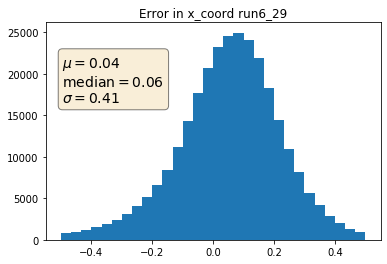

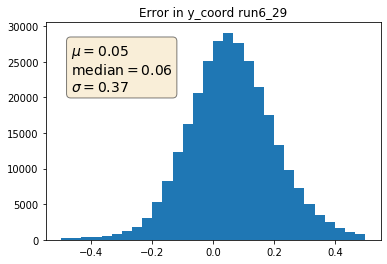

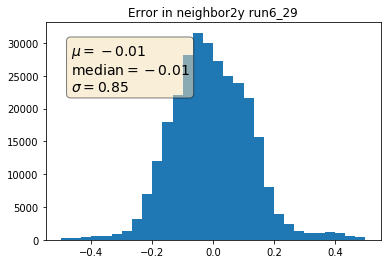

<Figure size 432x288 with 0 Axes>

In [37]:
#Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
model_name='run6_29'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))

arr_len=dfp.shape[0]
def get_error(column):
    diff= (dft[column].to_numpy()[:arr_len]-dfp[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()

#os.makedirs(os.path.join('Prediction_Plots',model_name))
plot_dir=os.path.join('Prediction_Plots',model_name)


def plot_error(error,name,_range=(-0.5,0.5)):
    mu, median, sigma =get_metrics(error)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(.05, 0.85, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.hist(error,bins=30,range=_range)
    plt.title('Error in ' + name +" "+ model_name)
    #plt.savefig(os.path.join(plot_dir,model_name+" error_"+name+".png"))
    plt.figure()
    
    
error_x=get_error('x_coord')
error_y=get_error('y_coord')
error_neighbor1x=get_error('neighbor1x')
error_neighbor1y=get_error('neighbor1y')
error_neighbor2x=get_error('neighbor2x')
error_neighbor2y=get_error('neighbor2y')
error_neighbor3x=get_error('neighbor3x')
error_neighbor3y=get_error('neighbor3y')


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure()
ax = plt.subplot(1,1,1)

plot_error(error_x,'x_coord')
plot_error(error_y,'y_coord')
plot_error(error_neighbor1x,'neighbor1x')
plot_error(error_neighbor1y,'neighbor1y')
plot_error(error_neighbor2x,'neighbor2x')
plot_error(error_neighbor2y,'neighbor2y')
plot_error(error_neighbor3x,'neighbor3x')
plot_error(error_neighbor3y,'neighbor3y')


plt.show

<function matplotlib.pyplot.show(*args, **kw)>

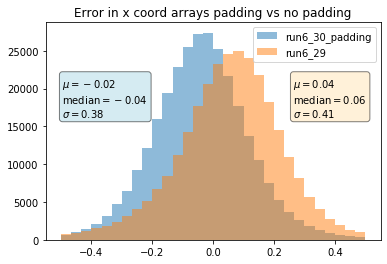

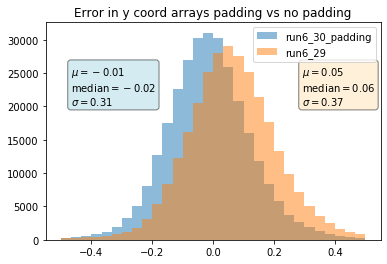

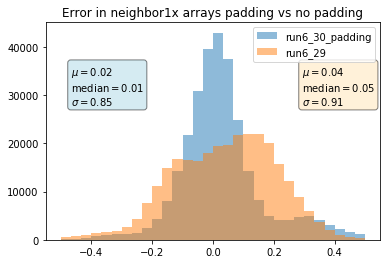

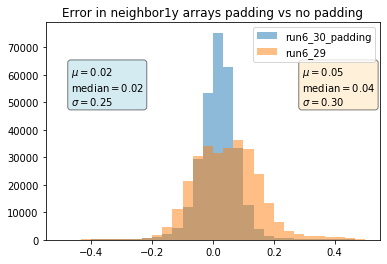

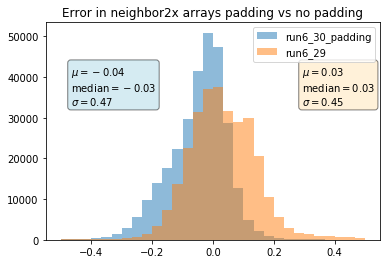

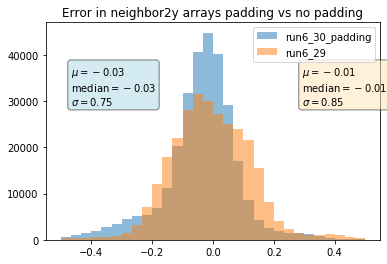

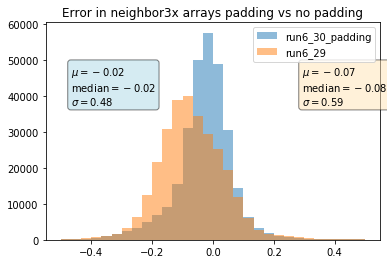

<Figure size 432x288 with 0 Axes>

In [40]:
#Code for comparing two models. Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
graph_name='arrays padding vs no padding'
model_name='run6_30_padding'
model_name_2='run6_29'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
test_dataset_dir_2 ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
prediction_dir_2=os.path.join("Training_Set_Predictions",model_name_2)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dft_2 = pd.read_csv(os.path.join(test_dataset_dir_2,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
dfp_2= pd.read_csv(os.path.join(prediction_dir_2,"predictions_dataframe.csv"))

def get_error(column):
    diff= (dft[column].to_numpy()-dfp[column].to_numpy())*32
    return diff

def get_error_2(column):
    diff= (dft_2[column].to_numpy()-dfp_2[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()

def plot_dual_error(data1,data2,name,range=(-0.5,0.5)):
    mu, median, sigma =get_metrics(data1)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    plt.text(.05, 0.75, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    mu, median, sigma =get_metrics(data2)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(.74, 0.75, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props_2)
    plt.hist(data1,bins=30,range=range,alpha=.5,label=model_name)
    plt.hist(data2,bins=30,range=range,alpha=.5,label=model_name_2)
    plt.legend(loc="upper right")
    plt.title('Error in ' +name+" "+ graph_name)
    plt.savefig(os.path.join(plot_dir,"Error in "+name+".png"))
    plt.figure()

os.makedirs(os.path.join('Prediction_Plots',graph_name))
plot_dir=os.path.join('Prediction_Plots',graph_name)

error_x=get_error('x_coord')
error_y=get_error('y_coord')
error_neighbor1x=get_error('neighbor1x')
error_neighbor1y=get_error('neighbor1y')
error_neighbor2x=get_error('neighbor2x')
error_neighbor2y=get_error('neighbor2y')
error_neighbor3x=get_error('neighbor3x')
error_neighbor3y=get_error('neighbor3y')

error_x_2=get_error_2('x_coord')
error_y_2=get_error_2('y_coord')
error_neighbor1x_2=get_error_2('neighbor1x')
error_neighbor1y_2=get_error_2('neighbor1y')
error_neighbor2x_2=get_error_2('neighbor2x')
error_neighbor2y_2=get_error_2('neighbor2y')
error_neighbor3x_2=get_error_2('neighbor3x')
error_neighbor3y_2=get_error_2('neighbor3y')


props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
props_2 = dict(boxstyle='round', facecolor='moccasin', alpha=0.5)
fig = plt.figure()
ax = plt.subplot(1,1,1)

plot_dual_error(error_x,error_x_2,"x coord")
plot_dual_error(error_y,error_y_2,"y coord")
plot_dual_error(error_neighbor1x,error_neighbor1x_2,"neighbor1x")
plot_dual_error(error_neighbor1y,error_neighbor1y_2,"neighbor1y")
plot_dual_error(error_neighbor2x,error_neighbor2x_2,"neighbor2x")
plot_dual_error(error_neighbor2y,error_neighbor2y_2,"neighbor2y")
plot_dual_error(error_neighbor3x,error_neighbor3x_2,"neighbor3x")
plot_dual_error(error_neighbor3y,error_neighbor3y_2,"neighbor3y")


plt.show

In [4]:
#Method for separting label array into useful data points
def split_label(labels):
    center_atom=np.array([labels[0],labels[1]])*32
    neighborvec1=np.array([labels[2],labels[3]])*32
    neighborvec2=np.array([labels[4],labels[5]])*32
    neighborvec3=np.array([labels[6],labels[7]])*32
    neighbors=[]
    neighbors.append(center_atom+neighborvec1)
    neighbors.append(center_atom+neighborvec2)
    neighbors.append(center_atom+neighborvec3)
    return center_atom , neighbors 

#Methods for coloring in the central atom and labels on the images.
def plot_labels():
    plt.plot(center_atom[0],center_atom[1],'o',color='black')
    plt.plot(neighbors[0][0],neighbors[0][1],'o',color='red')
    plt.plot(neighbors[1][0],neighbors[1][1],'o',color='green')
    plt.plot(neighbors[2][0],neighbors[2][1],'o',color='blue')

def plot_test_labels():
    plt.plot(center_atom_t[0],center_atom_t[1],'o',color='xkcd:gray')
    plt.plot(neighbors_t[0][0],neighbors_t[0][1],'o',color='xkcd:dark red')
    plt.plot(neighbors_t[1][0],neighbors_t[1][1],'o',color='xkcd:dark green')
    plt.plot(neighbors_t[2][0],neighbors_t[2][1],'o',color='xkcd:dark blue')


Gaussian= lambda x,scl,amp: amp*math.e**(-0.5*(x/scl)**2)
def plot_labels_3d():
    height=Gaussian(0,atom_size,corr)
    s=30
    ax.scatter3D(center_atom[0],center_atom[1],height,'o',color='black',s=s)
    ax.scatter3D(neighbors[0][0],neighbors[0][1],height,'o',color='red',s=s)
    ax.scatter3D(neighbors[1][0],neighbors[1][1],height,'o',color='green',s=s)
    ax.scatter3D(neighbors[2][0],neighbors[2][1],height,'o',color='blue',s=s)
    
def plot_test_labels_3d():
    height=Gaussian(0,atom_size,corr)
    s=30
    ax.scatter3D(center_atom_t[0],center_atom_t[1],height,'o',color='gray',s=s)
    ax.scatter3D(neighbors_t[0][0],neighbors_t[0][1],height,'o',color='xkcd:dark red',s=s)
    ax.scatter3D(neighbors_t[1][0],neighbors_t[1][1],height,'o',color='xkcd:dark green',s=s)
    ax.scatter3D(neighbors_t[2][0],neighbors_t[2][1],height,'o',color='xkcd:dark blue',s=s)


(-0.5, 31.5, 31.5, -0.5)

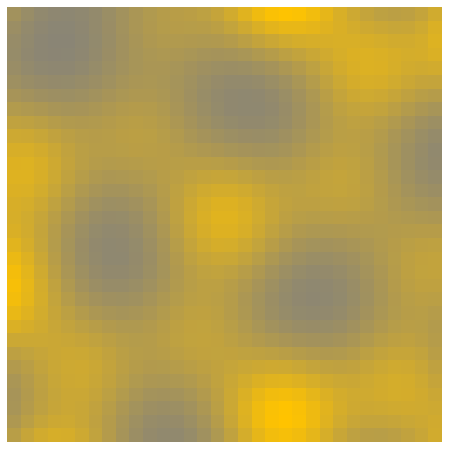

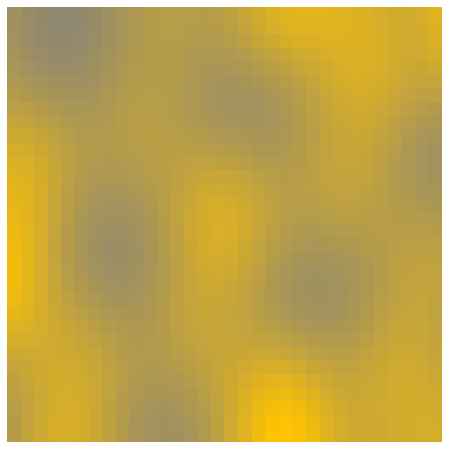

In [5]:
#ARRAY:Loads in a single testing image and plots its prediction vs true labels
model_name='run6_30_padding'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))




index=15134
im_filename=dft['filename'][index]
atom_size=dft['atom_size'][index]
corr=dft['corr'][index]+.1


test_im=np.load(os.path.join(test_dataset_dir,im_filename))

label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()
prediction_labels=dfp[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)
center_atom,neighbors=split_label(prediction_labels)

#os.makedirs(os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d")))
prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))


%matplotlib inline
im=STMImage(test_im)
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.imshow(im.image)
ax.axis('off')
#plot_test_labels()
#plot_labels()



filtered_im=gaussian_filter(test_im,[3,0])
im=STMImage(filtered_im)
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.imshow(im.image)
ax.axis('off')
#plot_test_labels()


# %matplotlib notebook
# z = gaussian_filter(test_im,[0,0])
# ny,nx = z.shape
# x = np.linspace(0,nx,nx)
# y = np.linspace(0,ny,ny)
# xv, yv = np.meshgrid(x,y)
# fig=plt.figure(figsize=(10,10))
# ax=fig.add_subplot(111,projection='3d')
# height3d=ax.plot_surface(xv,yv,z,linewidth=1,alpha=0.8)
# plot_labels_3d()
# plot_test_labels_3d()
# ax.set_zlabel('z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')


# z = gaussian_filter(test_im,[0,2])
# ny,nx = z.shape
# x = np.linspace(0,nx,nx)
# y = np.linspace(0,ny,ny)
# xv, yv = np.meshgrid(x,y)
# fig=plt.figure(figsize=(10,10))
# ax=fig.add_subplot(111,projection='3d')
# height3d=ax.plot_surface(xv,yv,z,linewidth=1,alpha=0.8)
# #plot_labels_3d()
# #plot_test_labels_3d()
# ax.set_zlabel('z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')

#plt.savefig(os.path.join(prediction_plots_dir,"small test train_image_"+str(index)+"_"+model_name))

<IPython.core.display.Javascript object>


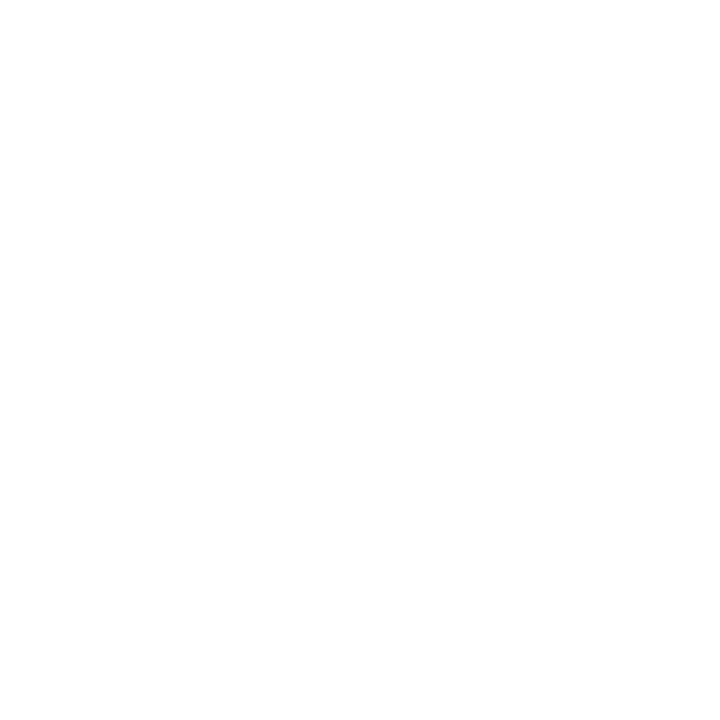

<IPython.core.display.Javascript object>


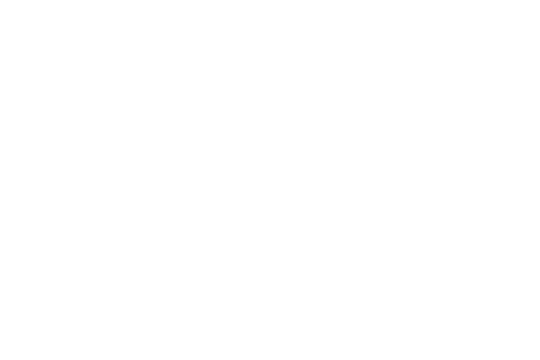

<IPython.core.display.Javascript object>


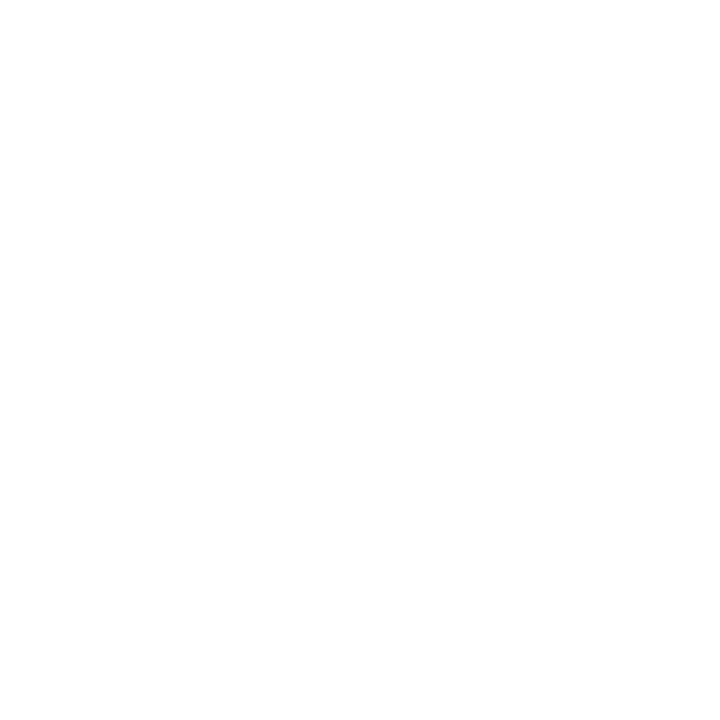

Text(0.5, 0, 'y')

<IPython.core.display.Javascript object>


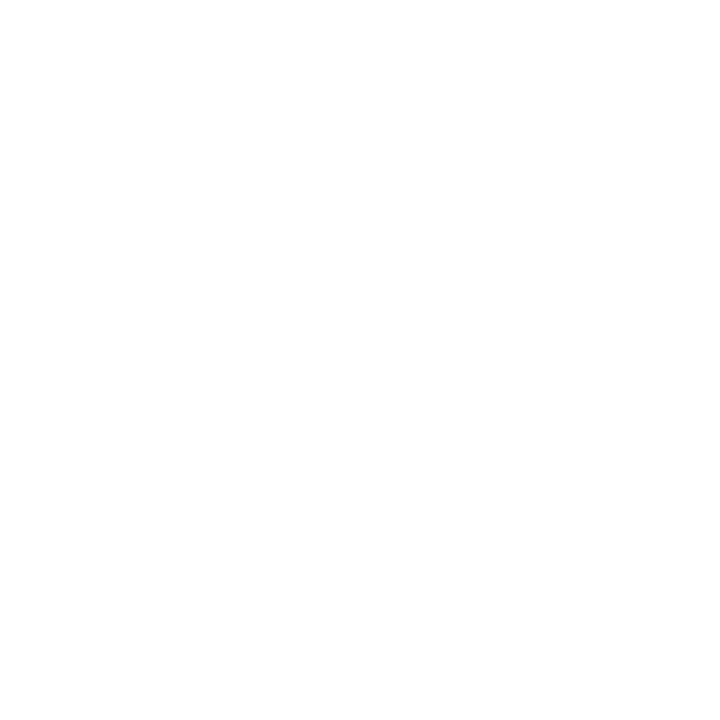

In [73]:
from scipy import interpolate

def crop_and_resample_2darray(arr, x_crop, y_crop, resample, *args, **kwargs):
    """Crop a 2darray and resize the data"""
    
    len_x_crop = x_crop[1]-x_crop[0]
    len_y_crop = y_crop[1]-y_crop[0]

    arr_crop = arr[x_crop[0]:x_crop[1], y_crop[0]:y_crop[1]]
    f = interpolate.interp2d(np.arange(len_y_crop), 
                             np.arange(len_x_crop), 
                             arr_crop, 
                             *args, **kwargs)
    result = f(np.arange(len_x_crop, step=len_x_crop/resample[1]), 
             np.arange(len_y_crop, step=len_y_crop/resample[0]))
    return result

stm=np.loadtxt('MoC2 _ 340.txt')

fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.imshow(stm,cmap='viridis')
ax.axis('off')
plt.figure()

x,y=(120,120)
size=32
stm_c=crop_and_resample_2darray(stm,[x,x+size],[y,y+size],[size,size])

%matplotlib notebook
#%matplotlib inline
ny,nx = stm.shape
x = np.linspace(0,nx,nx)
y = np.linspace(0,ny,ny)
xv, yv = np.meshgrid(x,y)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
height3d=ax.plot_surface(xv,yv,stm,linewidth=0,alpha=0.5)
#plot_labels_3d()
ax.set_zlabel('z')
ax.set_xlabel('x')
ax.set_ylabel('y')


# fig = plt.figure(figsize = (8, 8))
# ax = plt.subplot(1,1,1)
# ax.imshow(stm_c,cmap='viridis')
# ax.axis('off')


In [71]:
#Generator and predictor for real STM image. 

batch_stm=np.reshape(stm_c,(32,32,1))
batch_stm=np.expand_dims(batch_stm, axis=0)
prediction=model.predict(batch_stm)
prediction=prediction[0]

#assingns relevant datapoints
center_atom,neighbors=split_label(prediction)

In [68]:
#Plots the predictions on the STM image
model_name="run6_30_padding"
prediction_plots_dir=os.path.join('Prediction_Plots',model_name +" STM tests")

fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(stm_c,cmap='afmhot')
plot_labels()
#plt.savefig(os.path.join(prediction_plots_dir,))

# Older Code Snippets

In [3]:
# NOTICE: will only work with the datasets created using for loops, not for the random datasets
bl_list=np.linspace(7,9,num=4)
offx_list=np.linspace(-5,5,num=5)
offy_list=np.linspace(-5,5,num=5)
atom_size_list=np.linspace(2,3.5,num=3)
q_list=np.linspace(0,.1,num=5)
r_list=np.linspace(0,.1,num=5)
b_list=np.linspace(0,.1,num=5)
angle_list=np.linspace(-30,30,num=8)
#Returns the filename of a given image in the dataframe. Inputs are NOT the values of the parameters, they are the indicies, asking for the i'th value of each parameter. ie _bl=3 means the 4th value bl can take in the dataset
def get_filename(_bl,_offx,_offy,_a_s,_q,_r,_b,_angle):
    bl=bl_list[_bl]
    offx=offx_list[_offx]
    offy=offy_list[_offy]
    atom_size=atom_size_list[_a_s]
    q=q_list[_q]
    r=r_list[_r]
    b=b_list[_b]
    angle=angle_list[_angle]
    filename=f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png"
    return filename


In [ ]:
#IMAGE:Loads in a single testing image and plots its prediction vs true labels
model_name='run6_25_arrayinput'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Older Code and Training sets\\Training_set_6_25'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
#get_filename params are the indicies for (bond length, offx, offy, atom size, q, r, b, anlge)
#im_filename=get_filename(3,0,4,1,0,2,0,3)
#print(im_filename)
#index=np.flatnonzero(dft['filename']==im_filename)[0]
index=27742

test_im=image.load_img(os.path.join(test_dataset_dir,dft['filename'][index]))
test_im_arr=image.img_to_array(test_im)
test_im_arr_batch=np.array([test_im_arr])
label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()
prediction_labels=dfp[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)
center_atom,neighbors=split_label(prediction_labels)

prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

fig = plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(test_im)
plot_labels()
plot_test_labels()
#plt.savefig(os.path.join(prediction_plots_dir,"train_image_"+str(index)+"_"+model_name))

In [47]:
batch=np.reshape(test_im,(32,32,1))
batch=np.expand_dims(batch, axis=0)
prediction=model.predict(batch)
center_atom,neighbors=split_label(prediction[0])

In [82]:
#Loads in real STM images and crops them. Rescales cropped image to 32x32
def crop_STM(arr,xy,size):
    x,y = xy
    return arr[y:y+size,x:x+size]
image_offset=[155,71]
image_size=20
croping_box=(image_offset[0],image_offset[1],image_offset[0]+image_size,image_offset[1]+image_size)
im=image.load_img("MoC2 _ 349.jpg")
im_crop=im.crop(croping_box)
im_resize=im_crop.resize((32,32))
# im_arr=crop_STM(im_arr,image_offset,32)
# im_arr=np.array(Image.fromarray(im_arr).resize((32,32)))
im_arr=image.img_to_array(im_resize).astype('int')
im_arr_batch=np.array([im_arr])
plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)